In [1]:
import os
import gc
from tqdm import tqdm

import torch.nn as nn 
from torch.cuda import amp
from torchmetrics import MeanMetric

from inferenceLogger import InferenceLogger, InferType
from modelManager import ModelManager
from utils1 import get_default_device
from visualisations import visualize_data, visualize_forward, visualize_variance_schedule
from dataLoader import get_dataloader
from constantsManager import ConstantsManager

In [2]:
#todo show swiss roll denoising transitions
#todo explain training algorithm
#todo improve parameter transfers
#todo sample noise from multivariate distribution
#todo implement reverse process decoder?
#todo add different variance schedules

In [ ]:
BaseConfig = {
    'DEVICE' : get_default_device(),
    'DATASET' : "SWISS", # "SWISS", "MNIST", "Cifar-10", "Cifar-100", "Flowers" ...
}

TrainingConfig = {
    'SAMPLES_AMOUNT' : 1,
    'INFERENCE_TYPE' : InferType.NONE,
    'TIMESTEPS' : 40, # Define number of diffusion timesteps
    'NUM_EPOCHS' : 200,
    'BATCH_SIZE' : 512,
    'CHECKPOINT_PERIOD' : 50, #20
    'LR' : 2e-4,
    'NUM_WORKERS' : 0 # does not work for windows
}    
    
#todo replace with UNetConfig
ModelConfig = {
    #'IMG_SHAPE' : (1, 32, 32) if BaseConfig['DATASET'] == "MNIST" else (3, 32, 32), 
    'IMG_SHAPE' : 2,
    'BASE_CH' : 64,  # 64, 128, 256, 256
    #'BASE_CH_MULT' : (1, 2, 4, 8) if BaseConfig['DATASET'] == "MNIST" else (1, 2, 4, 4) ,
    'BASE_CH_MULT' : (1, 2, 4, 8),
    'APPLY_ATTENTION' : (False, True, True, False),
    'DROPOUT_RATE' : 0.1,
    'TIME_EMB_MULT' : 2 #4 # 128
}

In [ ]:
visualize_data(dataset_name="Flowers", amount=72)

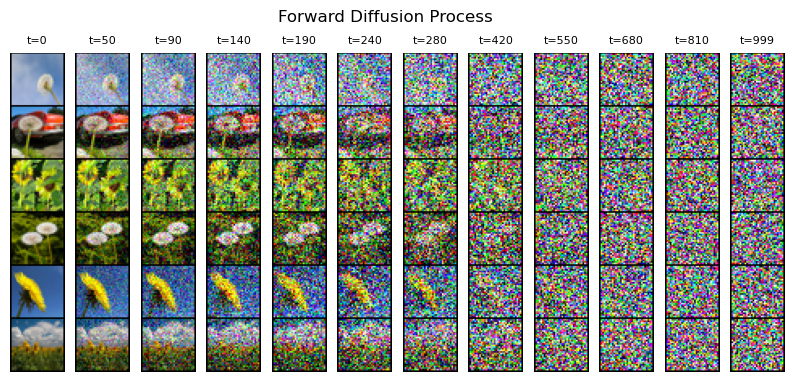

In [20]:
visualize_forward("Flowers")

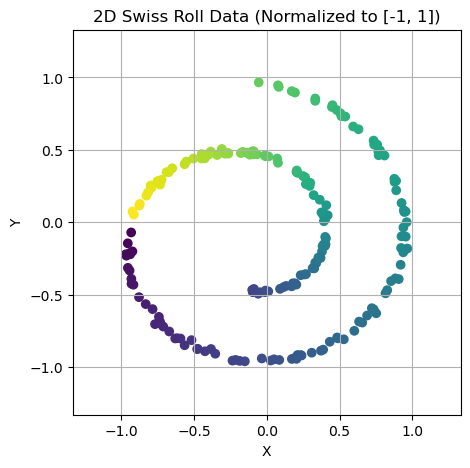

In [53]:
visualize_data(dataset_name=BaseConfig['DATASET'], amount=200)

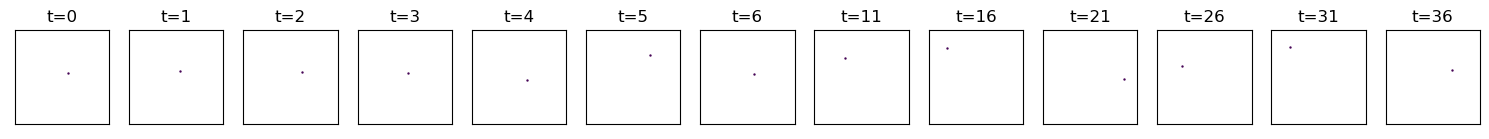

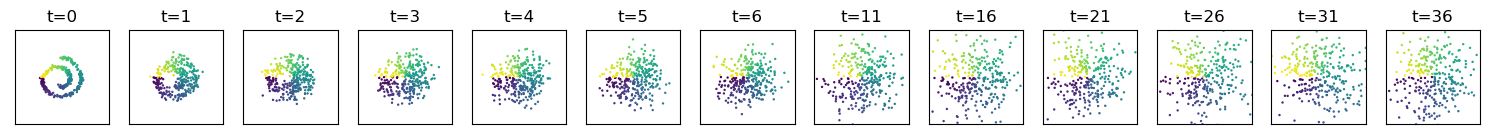

In [18]:
visualize_forward(dataset_name="SWISS", timesteps=40, batch_size=1)
#visualize_forward(dataset_name="SWISS", timesteps=40, batch_size=300)

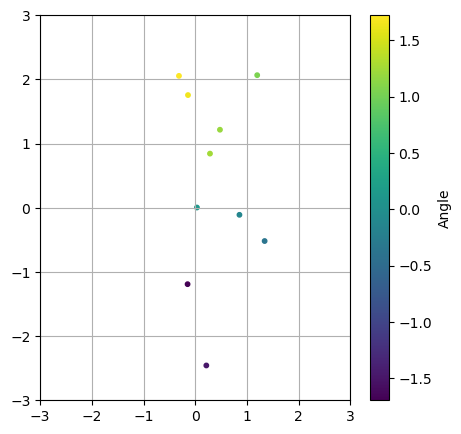

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 500x500 with 0 Axes>

In [102]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace x0 with your actual tensor)
x0 = torch.empty(10, 2)  # Example: empty tensor with the same shape as your actual data

# Generate points from a standard Gaussian distribution
gaussian_points = torch.randn_like(x0)
gaussian_points_np = gaussian_points.numpy()
# Scatter plot with reduced point size
plt.figure(figsize=(5, 5))
plt.scatter(gaussian_points_np[:, 0], gaussian_points_np[:, 1], c=np.arctan2(gaussian_points_np[:, 1], gaussian_points_np[:, 0]), cmap='viridis', s=10)  # Adjust the s parameter for point size
plt.colorbar(label='Angle')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()

    # sample noise from a multivariate normal distribution
mean = torch.zeros(x0.size(1))
identity_matrix = torch.eye(x0.size(1)) 
multivariate_normal = torch.distributions.MultivariateNormal(mean, identity_matrix)
e =  multivariate_normal.sample()

gaussian_points_np = e.numpy()
# Scatter plot with reduced point size
plt.figure(figsize=(5, 5))
plt.scatter(gaussian_points_np[:, 0], gaussian_points_np[:, 1], c=np.arctan2(gaussian_points_np[:, 1], gaussian_points_np[:, 0]), cmap='viridis', s=10)  # Adjust the s parameter for point size
plt.colorbar(label='Angle')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()

In [20]:
round_at = 0
uniform_steps = False
timesteps = 21
    
if uniform_steps:
        specific_timesteps = np.linspace(0, timesteps - 1, 12, dtype=int)

else:
        one_third = timesteps // 3
        two_thirds = timesteps - one_third
        stepsize1 = one_third // 7
        stepsize2 = two_thirds // 5
        first_half = np.arange(0, timesteps, stepsize1)[:7]
        second_half = np.arange(first_half[-1] + stepsize2, timesteps, stepsize2)[:12]
        specific_timesteps = np.concatenate((first_half, second_half))

if round_at != 0:
        specific_timesteps = np.round(specific_timesteps, round_at)

        if specific_timesteps[-1] <= timesteps:
            specific_timesteps[-1] = timesteps - 1
            
specific_timesteps

array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 12, 14, 16, 18, 20])

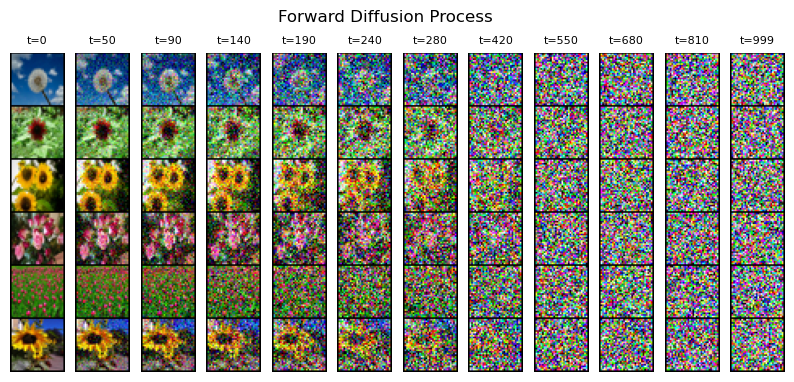

In [24]:
visualize_forward(dataset_name="Flowers",timesteps=1000)

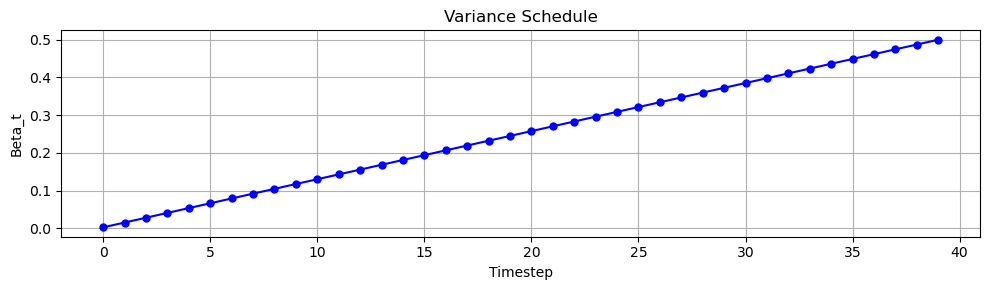

In [8]:
visualize_variance_schedule(timesteps=40)

$$
\Large x_t = \sqrt{\bar a_t}x_0 + \sqrt{1-\bar a_t}\epsilon
$$

In [90]:
def forward_diffusion(constants: ConstantsManager, x0: torch.Tensor, t: torch.Tensor):
    # Noise
    e = torch.randn_like(x0)  
    
    # image scaled + noise scaled
    x_t  = (constants.sqrt_alpha_cumulative_at(timesteps=t) * x0 + constants.sqrt_one_minus_alpha_cumulative_at(timesteps=t) * e)
    
    # return corrupted input and the corresponding noise applied
    return x_t, e   

![](.\resources\training.png)

In [6]:
# Algorithm 1: Training

def train_one_epoch(model, constants, loader, optimizer, scaler, loss_fn, epoch=800, 
                   base_config=BaseConfig, training_config=TrainingConfig):
    
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config['NUM_EPOCHS']}")
    
        for x0s, _ in loader:
            tq.update(1)
            # select random timesteps
            ts = torch.randint(low=1, high=training_config['TIMESTEPS'], size=(x0s.shape[0],), device=base_config['DEVICE'])
            # perform noising based on the variance schedule
            xts, gt_noise = forward_diffusion(constants, x0s, ts)
            
            with amp.autocast():
                pred_noise = model(xts, ts)
                loss = loss_fn(gt_noise, pred_noise)
                
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss 

![](.\resources\sampling.png)

In [7]:
# generates "num_images"-amount of samples
    
@torch.no_grad()
def generate_samples(model, constants, inference_logger, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, device="cpu"):

    
    # (multiples: x := [x1_T, x2_T ..., x(num_images)_T] )
    x_shape = (num_images, *img_shape) if isinstance(img_shape, tuple) else (num_images, img_shape)
    # 1: x_T ~ N(0,1)
    x = torch.randn(x_shape, device=device)
    model.eval()

    # 2: for t = T, ... ,1 do
    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        # 3: z ~ N(0,1) if t > 0, else z = 0
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        predicted_noise = model(x, ts)

        beta_t                            = constants.beta_at(timesteps=ts)
        one_by_sqrt_alpha_t               = constants.one_by_sqrt_alpha_at(timesteps=ts)
        sqrt_one_minus_alpha_cumulative_t = constants.sqrt_one_minus_alpha_cumulative_at(timesteps=ts)

        # 4: x_{t-1} = ...
        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )

        inference_logger.update(x)

    # 6: return x_0
    inference_logger.save_result(x)

In [58]:
#m = ModelManager(model_name="MNIST_DDPM", model_config=ModelConfig, checkpoint_name=None, type="UNET")
#todo remove model_config
m = ModelManager(model_name="SwissRoll10", checkpoint_name=None, type="FNN")
model = m.get_model()
model.to(BaseConfig['DEVICE'])

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig['LR'])
loss_fn = nn.MSELoss()
scaler = amp.GradScaler()

dataloader = get_dataloader(dataset_name=BaseConfig['DATASET'],
                            batch_size=TrainingConfig['BATCH_SIZE'],
                            num_workers=TrainingConfig['NUM_WORKERS'],
                            device=BaseConfig['DEVICE'])

constants = ConstantsManager(
    num_diffusion_timesteps = TrainingConfig['TIMESTEPS'],
    device                  = BaseConfig['DEVICE'],
    shape_2d=True
)

In [ ]:
for epoch in range(1, TrainingConfig['NUM_EPOCHS'] + 1):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, constants, dataloader, optimizer, scaler, loss_fn, 
                    epoch=epoch, base_config=BaseConfig, training_config=TrainingConfig)
    
    if epoch % TrainingConfig['CHECKPOINT_PERIOD'] == 0:
        
        if TrainingConfig['INFERENCE_TYPE'] != InferType.NONE:
            # Algorithm 2: Sampling
            generate_samples(
                model, constants, 
                timesteps=TrainingConfig['TIMESTEPS'],
                num_images=TrainingConfig['SAMPLES_AMOUNT'],
                inference_logger= InferenceLogger(
                    TrainingConfig['INFERENCE_TYPE'], 
                    m.get_inference_logs_path()),
                img_shape=ModelConfig['IMG_SHAPE'], 
                device=BaseConfig['DEVICE'],
            )
        
        m.update_checkpoint(optimizer, scaler, model)
        

# Inference

Sampling :: 100%|██████████| 39/39 [00:00<00:00, 1344.11it/s]


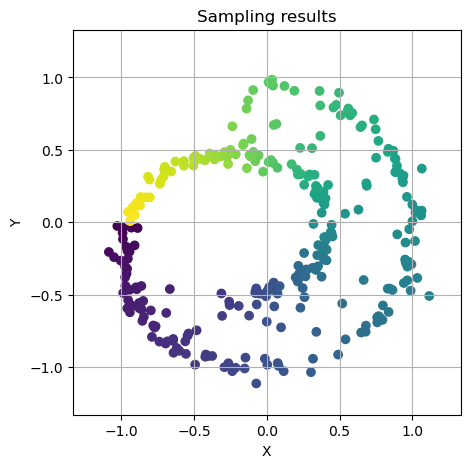

inference_results\denoising_points


In [98]:
# swiss roll
os.makedirs("inference_results", exist_ok=True)
filename = "denoising_points"
save_path = os.path.join("inference_results", filename)

generate_samples(
    model,
    constants,
    num_images=300,
    inference_logger=InferenceLogger(InferType.POINT, save_path),
    timesteps=40,
    img_shape=ModelConfig['IMG_SHAPE'],
    device=BaseConfig['DEVICE'],
)
print(save_path)

In [ ]:
# for image data
'''
os.makedirs("inference_results", exist_ok=True)
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}"
save_path = os.path.join("inference_results", filename)

generate_samples(
    model,
    sd,
    num_images=4,#16,
    inference_logger=InferenceLogger(InferType.VIDEO, save_path, nrow=4),
    timesteps=500,
    img_shape=ModelConfig['IMG_SHAPE'],
    device=BaseConfig['DEVICE'],
)
print(save_path)

'''